In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wsuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df_data_0['target'] = np.where(df_data_0['label']=='ham',0, 1)

In [5]:
df_data_0.head()

,label,message,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


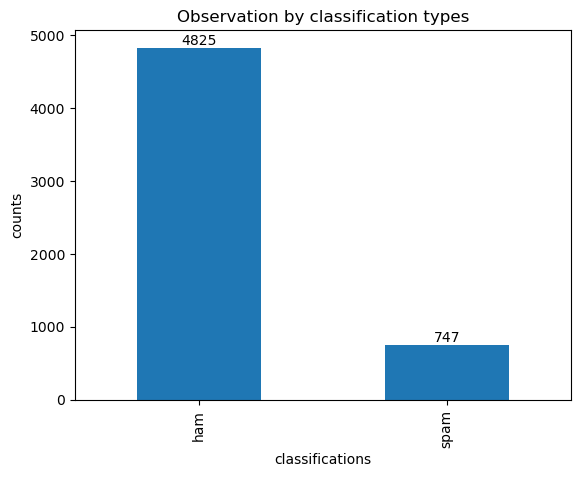

In [6]:
import matplotlib.pyplot as plt

#count the occurrences of each instance
label_counts = df_data_0['label'].value_counts()

#create a barplot
ax = label_counts.plot(kind='bar')
plt.title('Observation by classification types')
plt.xlabel('classifications')
plt.ylabel('counts')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()



In [7]:
df_data_1 = df_data_0.drop_duplicates(subset=['message'])

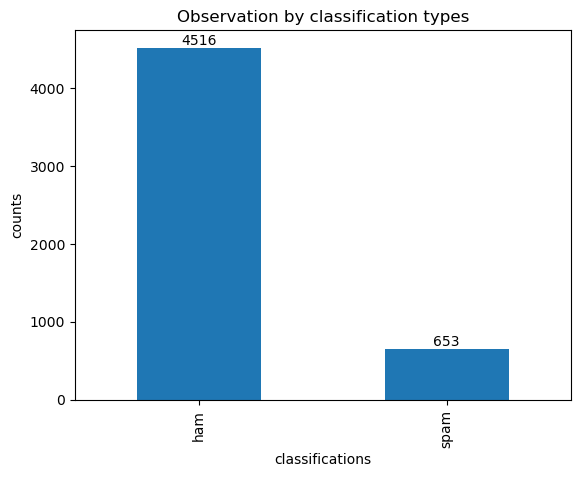

In [8]:
import matplotlib.pyplot as plt

#count the occurrences of each instance
label_counts = df_data_1['label'].value_counts()

#create a barplot
ax = label_counts.plot(kind='bar')
plt.title('Observation by classification types')
plt.xlabel('classifications')
plt.ylabel('counts')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()



In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(df_data_1['message'],
                                                    df_data_1['label'],
                                                    test_size=0.3,
                                                    random_state=0)

In [10]:
# Import necessary libraries for text processing
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase
    text = re.sub(r"\d+","",text)   #remove digits and currencies 
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates 
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks

    #remove stop words
    if rm_stop == True:
        filtered_tokens = [word for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)

    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)

    #stemming
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)

    return text

# Apply the text_clean function separately to X_train and X_test
preprocessed_X_train = X_train.apply(lambda x: text_clean(x, method='L', rm_stop=True))
preprocessed_X_test = X_test.apply(lambda x: text_clean(x, method='L', rm_stop=True))

In [13]:
def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset
    tfidf = TfidfVectorizer()
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)

    precision = precision_score(Y_test, predictions, pos_label='spam')


    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return model, predictions

Accuracy: 97.68 %
Balanced accuracy: 93.16 %
Precision: 94.59 %


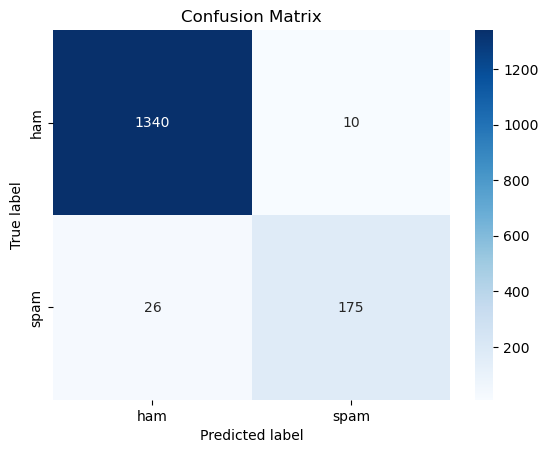

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Create a heatmap with seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Add labels and title
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()
    

# Transform the data and train the model
model, predictions = transform_model_data_w_tfidf_vectorizer(preprocessed_X_train, Y_train, preprocessed_X_test, Y_test)

# Plot the confusion matrix
plot_confusion_matrix(Y_test, predictions, labels=['ham', 'spam'])



In [15]:
print("X_train length:", len(X_train))
print("Y_train length:", len(Y_train))
print("X_test length:", len(X_test))
print("Y_test length:", len(Y_test))


X_train length: 3618
Y_train length: 3618
X_test length: 1551
Y_test length: 1551
